In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from glob import glob
import pymannkendall as mk
import seaborn as sn
import statsmodels.api as sm

In [2]:
df_anom = pd.read_csv("data/pos/tmean_anomaly_groups_kmeans.csv", index_col=0)
df_clim = pd.read_csv("data/pos/tmean_clim_groups_kmeans.csv", index_col=0)
df_tmean = pd.read_csv("data/pos/tmean_groups_kmeans.csv", index_col=0)
citys = pd.read_csv("data/statics/cidades.csv", index_col=2).drop(columns=['Unnamed: 0'])

In [3]:
def is_consecutive(days):
    if days>=1 and days<=3:
        return True
    else:
        return None

In [4]:
def calcule_ehf(df, group, verbose=False):
    p95 = df[group].quantile(0.9)
    data = list()
    for i in range(29, len(df[group])):
        try:
            time = df.index[i+3]
            temperature_mean = df[group].iloc[i+3]
            last3days = df[group].iloc[i:i+3]
            last30days = df[group].iloc[i-29:i]
            
            ehfsig = last3days.mean() - p95
            ehfacl = last3days.mean() - last30days.mean()

            # print(i)
            # print((i,i+3))
            # print(last3days)
            # print((i-29,i))
            # print(last30days)
            # print(time)
            
            EHF = max(0, ehfsig) * max(1, ehfacl)
            data.append({
                'time':time, 'temperature_mean':temperature_mean, 'ehfsig':ehfsig, 'ehfacl':ehfacl, 'EHF':EHF
            })

        except Exception as e:
            print(e)
            
    df_ehf = pd.DataFrame(data)
    df_ehf.index = df_ehf.time
    df_ehf['severity'] = df_ehf[df_ehf.EHF>0]['EHF'] / df_ehf[df_ehf.EHF>0]['EHF'].quantile(0.85)
    return df_ehf

In [7]:
# df_ehf = calcule_ehf(df_tmean, group='G1', verbose=False)
# df_ehf = df_ehf[df_ehf['EHF']>0]


# times = pd.to_datetime(df_ehf.time.values)

# c = 0

# df_hws = list()
# periods = list()
# heatwaves = list()

# for i, timenow in enumerate(df_ehf.time):
#     timenow = pd.Timestamp(timenow)
    
#     if i == 0:
#         heatwaves.append(timenow)
#         c += 1
        
#     else:
#         days = (timenow - times[i-1]).days
#         if is_consecutive(days):
#             if c == 0:
#                 heatwaves.append(times[i-1])
#             heatwaves.append(times[i])
#             c += 1
#         else:         
            
#             if len(heatwaves)>1:
#                 periods.append(heatwaves)
#                 df_hw = df_ehf.loc[heatwaves[0].strftime('%Y-%m-%d'):heatwaves[-1].strftime('%Y-%m-%d')]
#                 init = pd.to_datetime(df_hw['time'].values[0]) - timedelta(days=2)
#                 end = pd.to_datetime(df_hw['time'].values[-1])
#                 lenght = len(df_hw) + 2
#             elif len(heatwaves)==1:
#                 df_hw = df_ehf.loc[heatwaves[0].strftime('%Y-%m-%d')]
#                 init = pd.to_datetime(df_hw['time']) - timedelta(days=2)
#                 end = pd.to_datetime(df_hw['time'])
#                 lenght = 3

            
            
#             ehf_peak = [df_hw['EHF'].max()]
#             ehf_load = [df_hw['EHF'].sum()]
#             ehf_mean = [df_hw['EHF'].mean()]

#             severity_peak = [df_hw['severity'].max()]
#             severity_load = [df_hw['severity'].sum()]
#             severity_mean = [df_hw['severity'].mean()]

#             df_hws.append(

#                 pd.DataFrame({
#                     'init':init, 'end':end, 'lenght':lenght, 
#                     'ehf_peak':ehf_peak, 'ehf_load':ehf_load, 'ehf_mean':ehf_mean, 
#                     'severity_peak':severity_peak, 'severity_load':severity_load, 'severity_mean':severity_mean,
#                 })
                
#             )
            
            
#             c = 0
#             heatwaves = list()

# df_hws = pd.concat(df_hws)
# df_hws['year'] = list(map(lambda d: d.year, df_hws['init']))
# df_hws['month'] = list(map(lambda d: d.month, df_hws['init']))

In [8]:
def detect_hw(df, group_name):
    df_ehf = calcule_ehf(df, group=group_name, verbose=False)
    df_ehf = df_ehf[df_ehf['EHF']>0]
    
    
    times = pd.to_datetime(df_ehf.time.values)
    
    c = 0
    
    df_hws = list()
    periods = list()
    heatwaves = list()
    
    for i, timenow in enumerate(df_ehf.time):
        timenow = pd.Timestamp(timenow)
        
        if i == 0:
            heatwaves.append(timenow)
            c += 1
            
        else:
            days = (timenow - times[i-1]).days
            if is_consecutive(days):
                if c == 0:
                    heatwaves.append(times[i-1])
                heatwaves.append(times[i])
                c += 1
            else:         
                
                if len(heatwaves)>1:
                    periods.append(heatwaves)
                    df_hw = df_ehf.loc[heatwaves[0].strftime('%Y-%m-%d'):heatwaves[-1].strftime('%Y-%m-%d')]
                    init = pd.to_datetime(df_hw['time'].values[0]) - timedelta(days=2)
                    end = pd.to_datetime(df_hw['time'].values[-1])
                    lenght = len(df_hw) + 2
                elif len(heatwaves)==1:
                    df_hw = df_ehf.loc[heatwaves[0].strftime('%Y-%m-%d')]
                    init = pd.to_datetime(df_hw['time']) - timedelta(days=2)
                    end = pd.to_datetime(df_hw['time'])
                    lenght = 3
    
                
                
                ehf_peak = [df_hw['EHF'].max()]
                ehf_load = [df_hw['EHF'].sum()]
                ehf_mean = [df_hw['EHF'].mean()]
    
                severity_peak = [df_hw['severity'].max()]
                severity_load = [df_hw['severity'].sum()]
                severity_mean = [df_hw['severity'].mean()]
    
                df_hws.append(
    
                    pd.DataFrame({
                        'init':init, 'end':end, 'lenght':lenght, 
                        'ehf_peak':ehf_peak, 'ehf_load':ehf_load, 'ehf_mean':ehf_mean, 
                        'severity_peak':severity_peak, 'severity_load':severity_load, 'severity_mean':severity_mean,
                    })
                    
                )
                
                
                c = 0
                heatwaves = list()
    
    df_hws = pd.concat(df_hws)
    df_hws['year'] = list(map(lambda d: d.year, df_hws['init']))
    df_hws['month'] = list(map(lambda d: d.month, df_hws['init']))
    return df_hws

index 10950 is out of bounds for axis 0 with size 10950
index 10951 is out of bounds for axis 0 with size 10950
index 10952 is out of bounds for axis 0 with size 10950


<Axes: xlabel='time'>

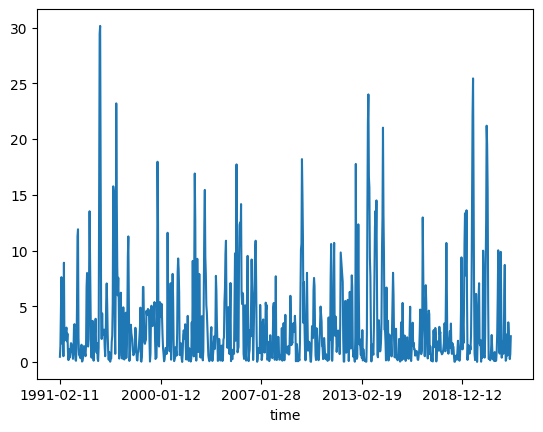

In [26]:
df = calcule_ehf(df_tmean, group='G3', verbose=False)
df[df['EHF']>0]['EHF'].plot()

<Axes: xlabel='time'>

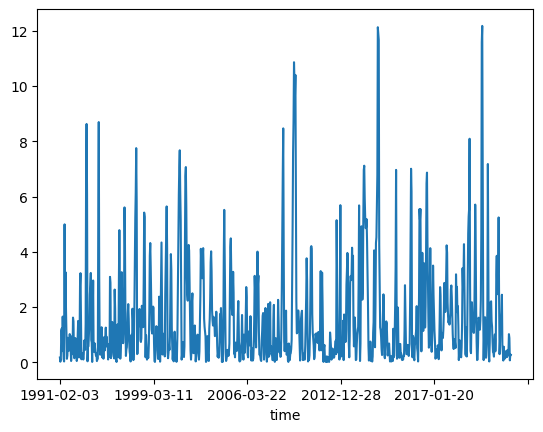

In [ ]:
G1 = detect_hw(df_tmean, group_name='G1')
G2 = detect_hw(df_tmean, group_name='G2')
G3 = detect_hw(df_tmean, group_name='G3')
G4 = detect_hw(df_tmean, group_name='G4')

In [ ]:
def NDOC(group):
    return group.groupby(group.year)['lenght'].sum()

def NEOC(group):
    return group.groupby(group.year)['lenght'].count()

def TMOC(group):
    return group.groupby(group.year)['lenght'].max()

def SMOC(group):
    return group.groupby(group.year)['severity_peak'].max()

In [ ]:
G1.head()

In [ ]:
G4.groupby(G4.year)['severity_peak'].max().plot()

In [ ]:
def test_mann_kendall(dados, title):
    resultado = mk.original_test(dados, alpha=0.05)
    # print(title)
    # print(f"Tendência: {resultado.trend}")
    # print(f"Slope: {float(resultado.slope)}")
    # print(f"{title}: Significância (p <= 0.05): {'Rejeita H0 (há tendência)' if resultado.p <= 0.05 else 'Não rejeita H0 (sem tendência)'}")
    # print('--'*5)
    values = f"Coef.: {round(float(resultado.slope),1)}.\nInterc.: {round(float(resultado.intercept),1)}.\np-value: {round(float(resultado.p),3)}"
    if resultado.p <= 0.05:
        color, msg = 'red', f'{title}:\nRejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),1)}.\nInterc.: {round(float(resultado.intercept),1)}.\np-value: {round(float(resultado.p),3)}'
    else:
        color, msg = 'black', f'{title}:\nNão rejeita H0 (sem tendência).\nCoef.: {round(float(resultado.slope),1)}.\nInterc.: {round(float(resultado.intercept),1)}.\np-value: {round(float(resultado.p),3)}'
    return resultado, msg

In [ ]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}


fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(NDOC(G1), label='G1', color='orange')
resultado, msg = test_mann_kendall(NDOC(G1), f'G1 - NDOC')
trend_line = np.arange(len(NDOC(G1))) * resultado.slope + resultado.intercept
ax[0].plot(NDOC(G1).index, trend_line, color='black')
msgs.append(msg)

# ax[0].plot(NDOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NDOC(G2), f'G2 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NDOC(G3), f'G3 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NDOC(G4), f'G4 - NDOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[0].set_ylabel('NDOC', fontsize=12)
ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(NEOC(G1), label='G1', color='orange')
resultado, msg = test_mann_kendall(NEOC(G1), f'G1 - NEOC')
trend_line = np.arange(len(NEOC(G1))) * resultado.slope + resultado.intercept
ax[1].plot(NEOC(G1).index, trend_line, color='black')
msgs.append(msg)
# ax[1].plot(NEOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NEOC(G2), f'G2 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NEOC(G3), f'G3 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NEOC(G4), f'G4 - NEOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[1].set_ylabel('NEOC', fontsize=12)
ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(TMOC(G1), label='G1', color='orange')
resultado, msg = test_mann_kendall(TMOC(G1), f'G1 - TMOC')
trend_line = np.arange(len(TMOC(G1))) * resultado.slope + resultado.intercept
ax[2].plot(TMOC(G1).index, trend_line, color='black')
msgs.append(msg)
# ax[2].plot(TMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G2 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G3 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - TMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo
    
ax[2].set_ylabel('TMOC', fontsize=12)
ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(SMOC(G1), label='G1', color='orange')
resultado, msg = test_mann_kendall(SMOC(G1), f'G1 - SMOC')
trend_line = np.arange(len(SMOC(G1))) * resultado.slope + resultado.intercept
ax[3].plot(SMOC(G1).index, trend_line, color='black')
msgs.append(msg)
# ax[3].plot(SMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G2), f'G2 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G3), f'G3 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - SMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[3].set_ylabel('SMOC', fontsize=12)
ax[3].set_xlabel('Anos')
ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()

In [ ]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}


fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(NDOC(G2), label='G2', color='orange')
resultado, msg = test_mann_kendall(NDOC(G2), f'G2 - NDOC')
trend_line = np.arange(len(NDOC(G2))) * resultado.slope + resultado.intercept
ax[0].plot(NDOC(G2).index, trend_line, color='black')
msgs.append(msg)

# ax[0].plot(NDOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NDOC(G2), f'G2 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NDOC(G3), f'G3 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NDOC(G4), f'G4 - NDOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[0].set_ylabel('NDOC', fontsize=12)
ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(NEOC(G2), label='G2', color='orange')
resultado, msg = test_mann_kendall(NEOC(G2), f'G2 - NEOC')
trend_line = np.arange(len(NEOC(G2))) * resultado.slope + resultado.intercept
ax[1].plot(NEOC(G2).index, trend_line, color='black')
msgs.append(msg)
# ax[1].plot(NEOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NEOC(G2), f'G2 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NEOC(G3), f'G3 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NEOC(G4), f'G4 - NEOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[1].set_ylabel('NEOC', fontsize=12)
ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(TMOC(G2), label='G2', color='orange')
resultado, msg = test_mann_kendall(TMOC(G2), f'G2 - TMOC')
trend_line = np.arange(len(TMOC(G2))) * resultado.slope + resultado.intercept
ax[2].plot(TMOC(G2).index, trend_line, color='black')
msgs.append(msg)
# ax[2].plot(TMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G2 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G3 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - TMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo
    
ax[2].set_ylabel('TMOC', fontsize=12)
ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(SMOC(G2), label='G2', color='orange')
resultado, msg = test_mann_kendall(SMOC(G2), f'G2 - SMOC')
trend_line = np.arange(len(SMOC(G2))) * resultado.slope + resultado.intercept
ax[3].plot(SMOC(G2).index, trend_line, color='black')
msgs.append(msg)
# ax[3].plot(SMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G2), f'G2 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G3), f'G3 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - SMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[3].set_ylabel('SMOC', fontsize=12)
ax[3].set_xlabel('Anos')
ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()

In [ ]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}


fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(NDOC(G3), label='G3', color='orange')
resultado, msg = test_mann_kendall(NDOC(G3), f'G3 - NDOC')
trend_line = np.arange(len(NDOC(G3))) * resultado.slope + resultado.intercept
ax[0].plot(NDOC(G3).index, trend_line, color='black')
msgs.append(msg)

# ax[0].plot(NDOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NDOC(G2), f'G2 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NDOC(G3), f'G3 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NDOC(G4), f'G4 - NDOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[0].set_ylabel('NDOC', fontsize=12)
ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(NEOC(G3), label='G3', color='orange')
resultado, msg = test_mann_kendall(NEOC(G3), f'G3 - NEOC')
trend_line = np.arange(len(NEOC(G3))) * resultado.slope + resultado.intercept
ax[1].plot(NEOC(G3).index, trend_line, color='black')
msgs.append(msg)
# ax[1].plot(NEOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NEOC(G2), f'G2 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NEOC(G3), f'G3 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NEOC(G4), f'G4 - NEOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[1].set_ylabel('NEOC', fontsize=12)
ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(TMOC(G3), label='G3', color='orange')
resultado, msg = test_mann_kendall(TMOC(G3), f'G3 - TMOC')
trend_line = np.arange(len(TMOC(G3))) * resultado.slope + resultado.intercept
ax[2].plot(TMOC(G3).index, trend_line, color='black')
msgs.append(msg)
# ax[2].plot(TMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G2 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G3 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - TMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo
    
ax[2].set_ylabel('TMOC', fontsize=12)
ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(SMOC(G3), label='G3', color='orange')
resultado, msg = test_mann_kendall(SMOC(G3), f'G3 - SMOC')
trend_line = np.arange(len(SMOC(G3))) * resultado.slope + resultado.intercept
ax[3].plot(SMOC(G3).index, trend_line, color='black')
msgs.append(msg)
# ax[3].plot(SMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G2), f'G2 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G3), f'G3 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - SMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[3].set_ylabel('SMOC', fontsize=12)
ax[3].set_xlabel('Anos')
ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()

In [ ]:
group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}


fig, ax = plt.subplots(4,1, figsize=(8, 6), dpi=200, sharex=True)

msgs = list()
ax[0].plot(NDOC(G4), label='G4', color='orange')
resultado, msg = test_mann_kendall(NDOC(G4), f'G4 - NDOC')
trend_line = np.arange(len(NDOC(G4))) * resultado.slope + resultado.intercept
ax[0].plot(NDOC(G4).index, trend_line, color='black')
msgs.append(msg)

# ax[0].plot(NDOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NDOC(G2), f'G2 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NDOC(G3), f'G3 - NDOC')
# msgs.append(msg)

# ax[0].plot(NDOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NDOC(G4), f'G4 - NDOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[0].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[0].set_ylabel('NDOC', fontsize=12)
ax[0].set_ylim(0,140)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()
ax[0].legend()


msgs = list()
ax[1].plot(NEOC(G4), label='G4', color='orange')
resultado, msg = test_mann_kendall(NEOC(G4), f'G4 - NEOC')
trend_line = np.arange(len(NEOC(G4))) * resultado.slope + resultado.intercept
ax[1].plot(NEOC(G4).index, trend_line, color='black')
msgs.append(msg)
# ax[1].plot(NEOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(NEOC(G2), f'G2 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(NEOC(G3), f'G3 - NEOC')
# msgs.append(msg)
# ax[1].plot(NEOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(NEOC(G4), f'G4 - NEOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[1].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[1].set_ylabel('NEOC', fontsize=12)
ax[1].set_ylim(0,15)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

msgs = list()
ax[2].plot(TMOC(G4), label='G4', color='orange')
resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - TMOC')
trend_line = np.arange(len(TMOC(G4))) * resultado.slope + resultado.intercept
ax[2].plot(TMOC(G4).index, trend_line, color='black')
msgs.append(msg)
# ax[2].plot(TMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G2 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G3 - TMOC')
# msgs.append(msg)
# ax[2].plot(TMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - TMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[2].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo
    
ax[2].set_ylabel('TMOC', fontsize=12)
ax[2].set_ylim(0,50)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].grid()


msgs = list()
ax[3].plot(SMOC(G4), label='G4', color='orange')
resultado, msg = test_mann_kendall(SMOC(G4), f'G4 - SMOC')
trend_line = np.arange(len(SMOC(G4))) * resultado.slope + resultado.intercept
ax[3].plot(SMOC(G4).index, trend_line, color='black')
msgs.append(msg)
# ax[3].plot(SMOC(G2), label='G2', color='green')
# resultado, msg = test_mann_kendall(TMOC(G2), f'G2 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G3), label='G3', color='red')
# resultado, msg = test_mann_kendall(TMOC(G3), f'G3 - SMOC')
# msgs.append(msg)
# ax[3].plot(SMOC(G4), label='G4', color='purple')
# resultado, msg = test_mann_kendall(TMOC(G4), f'G4 - SMOC')
# msgs.append(msg)

x, y = 1.02, 0.5
for msg in msgs:
    ax[3].annotate(msg, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.3  # Movendo para baixo para o próximo grupo

ax[3].set_ylabel('SMOC', fontsize=12)
ax[3].set_xlabel('Anos')
ax[3].set_ylim(0,5)
ax[3].grid()

plt.show()